# Random Forest Grid Search

Machine Learning Titanic. Currently, my decision tree scores top 6%. I scored top 5% using both random forest and xgBoost:
https://github.com/ScottySchmidt/Kaggle/blob/main/Titanic.ipynb
https://github.com/ScottySchmidt/Kaggle/blob/main/xgbTop5%25.ipynb

My goal is to try to use GridSearch and tunning more extensively on random forest to try to get a top 1%.

# Train Data
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and whether they survive or not. The shape of the train data is (891, 12). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
from math import sqrt

train=r'/kaggle/input/titanic/train.csv'
test=r'/kaggle/input/titanic/test.csv' 

df=pd.read_csv(train)
test=pd.read_csv(test)

print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
#Check Duplicates:
dupstr = df.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))
df[dupstr]

Total no of duplicate values in Training Dataset = 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [4]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
dtype: float64


# Feature Engineer
We need to replace male and female into numbers. This is a very important part of the process because gender is one of the highest predictors on if a person survived or not.

In [5]:
#GENDER
df['Sex']=df['Sex'].map({'female':0,'male':1})

Females whose number is 0 had a much higher chance of surving than males. Later on, doing the importance feature analysis we will view that gender is actually one of the highest predictors. 

In [6]:
genderTable = pd.crosstab(df['Survived'],df['Sex'])
genderTable

Sex,0,1
Survived,,
0,81,468
1,233,109


# Encode Categorical Variables
Encode Categorical Variables is needed for this dataset since there are many important variables that are not numeric yet. 

There are three classes C, Q, and S. Class C seems to have the highest chance of survival. Class S has the lowest chance of survival. Unfornately this would tend to show that economic status seems to played a part in the decision if someone survived or not. Embarked does not play role major role in feature importance. 

In [7]:
import category_encoders as ce
#encoder = ce.OrdinalEncoder(cols=['Embarked'])

#df = encoder.fit_transform(df)
#test = encoder.fit_transform(test)
#test.head()

# Examine Target Variable
Survived is the Y variable we will be analyzing. Since the survival rete is 0.384 the data is not considered unbalanced. 

In [8]:
temp=df['Survived'].value_counts()
print(temp)
no=temp[0]
yes=temp[1]
percent=round(yes/(yes+no),3)
print("Percent that survived: ", percent)

0    549
1    342
Name: Survived, dtype: int64
Percent that survived:  0.384


# Numeric DataFrame
For now, we will analyze only numeric values. Categorical values will need to be encoded or analyzed individually.

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1,0,7.2500
1,2,1,1,0,38.0,1,0,71.2833
2,3,1,3,0,26.0,0,0,7.9250
3,4,1,1,0,35.0,1,0,53.1000
4,5,0,3,1,35.0,0,0,8.0500


# Check for missing values
Age is missing around 20% of values.Therefore, we can simply fill in the mean for that one column.

In [10]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Age            0.198653
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
dtype: float64


In [11]:
df= df.fillna(df.mean())

# Split Data

In [12]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42)

# Highly Correlated Features
There are no highly correlated variables above 80%. Therefore, we do not need to be concerned about removing variables that are too highly correlated. 

# Tunning Forest
Random forest AUC:  0.8503 which is good results considering forest does not overfit data.

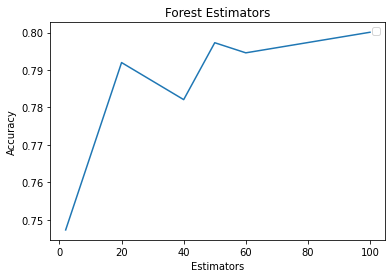

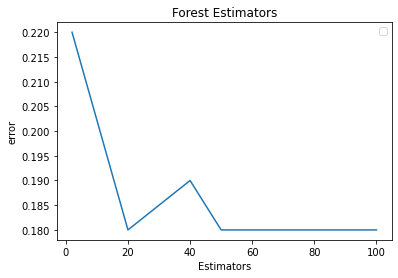

In [13]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#Check for Error and find Best n_estimators:
def forestNumEst():
    numbers= [2, 20, 40, 50, 60, 100]
    maeList=[] #error
    accList=[]
    
    for n in numbers:
        forest = RandomForestClassifier(n_estimators=n)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
        forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        #print("Random forest AUC: ", forest_auc) 
      
        accList.append(forest_auc)
        maeList.append(mae)
        
    plt.plot(numbers,accList)
    plt.title("Forest Estimators" )
    plt.xlabel("Estimators")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
    plt.plot(numbers, maeList)
    plt.title("Forest Estimators" )
    plt.xlabel("Estimators")
    plt.ylabel('error')
    plt.legend()
    plt.show() 

forestNumEst() 

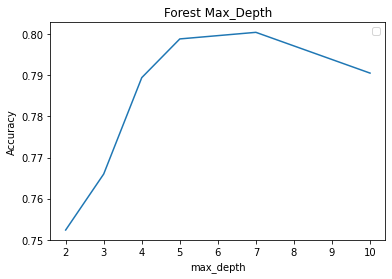

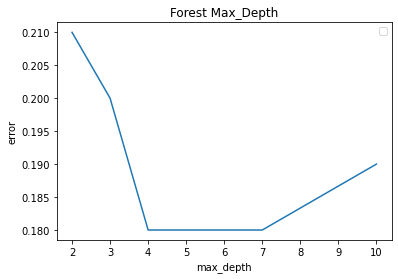

In [14]:
def forestDepth():
    numbers=[None, 2, 3, 4, 5, 7, 10]
    accList=[] #accuracy train data
    maeList=[] #error
    
    for n in numbers:
        forest = RandomForestClassifier(max_depth=n)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
        forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        #print("Random forest AUC: ", forest_auc) 
       
        accList.append(forest_auc)
        maeList.append(mae)
        
    plt.plot(numbers,accList)
    plt.title("Forest Max_Depth")
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
    plt.plot(numbers, maeList)
    plt.title("Forest Max_Depth")
    plt.xlabel("max_depth")
    plt.ylabel('error')
    plt.legend()
    plt.show() 

forestDepth()

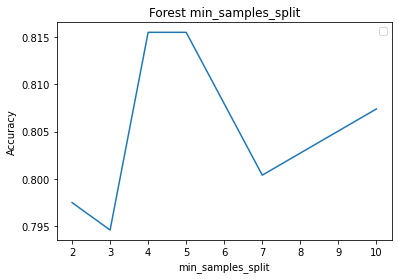

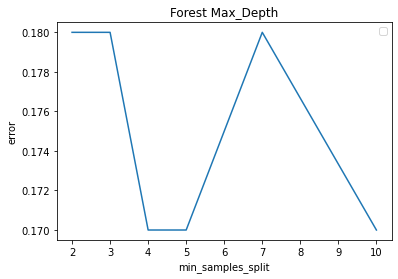

In [15]:
def forestSplit():
    numbers=[2, 3, 4, 5, 7, 10]
    accList=[] #accuracy train data
    maeList=[] #error
    
    for n in numbers:
        forest = RandomForestClassifier(min_samples_split=n)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
        forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        #print("Random forest AUC: ", forest_auc) 
       
        accList.append(forest_auc)
        maeList.append(mae)
        
    plt.plot(numbers,accList)
    plt.title("Forest min_samples_split")
    plt.xlabel('min_samples_split')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
    plt.plot(numbers, maeList)
    plt.title("Forest Max_Depth")
    plt.xlabel("min_samples_split")
    plt.ylabel('error')
    plt.legend()
    plt.show() 

forestSplit()

# GridSearch CV

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[20, 30, 40, 50, 60, 100],
    'max_depth':[5, 6, 7, 8],
    'min_samples_split':[2, 3, 4, 5],
    #'max_features':['auto', 'sqrt', 'log2'],
    #'criterion':['gini', 'entropy'],
}

forestGrid=GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, cv=10, scoring='accuracy')
forestGrid.fit(X_train, y_train)
forestGrid.best_params_

{'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 20}

#### Final Random Forest Prediction
* Top 5% Using {'max_depth': 5, 'n_estimators': 60} 0.79425

In [17]:
forestFinal = RandomForestClassifier(
   n_estimators=40, 
   max_depth=8,
   min_samples_split=5,
   #criterion='entropy',
   # max_features='auto',
)
forestFinal.fit(X_train, y_train)
y_pred = forestFinal.predict(X_test)

#Print Metrics:
forest_r2 = r2_score(y_test, y_pred).round(4)  
forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("Random forest AUC: ", forest_auc) 

mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Random forest MAE: ", mae)

forestScore =  forestFinal.score(X_test, y_test).round(4)  
forestCV = cross_validate(forestFinal, X, y, cv = 5, scoring='accuracy')
forestCV=forestCV['test_score'].mean().round(4)
print(forestScore)
print(forestCV)
print(forestScore-forestCV)

Random forest AUC:  0.7933
Random forest MAE:  0.18
0.8169
0.8037
0.01319999999999999


# Support Vector 
The initial results for SVM AUC with no parameter tunning is 0.5336.  The model does not seem worth investing lots of time into due to poor AUC performance. 

#### GridSearch Tune
The best parameters from tunning SVM is SVC(C=1000, gamma=0.0001).

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
 
def tuneSVM():
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

#### Final SVM Prediction

In [19]:
#Fit and Predict:
def runSVM():
    svm=SVC(C=1000, gamma=0.0001, kernel = 'linear')
    svm.fit(X_train, y_train)
    svmPedict = svm.predict(X_test)
    np.shape(svmPedict)
    np.shape(y_test)
    #y_class = np.argmax(y_pred, axis = 0)

    #calculate AUC of model
    svmAUC = round( metrics.roc_auc_score(y_test, svmPedict, multi_class='ovr'), 4 ) 
    print("SVC AUC is: ", svmAUC)

    svmR2 = r2_score(y_test, svmPedict).round(4) 
    print("SVM r2: ", svmR2) 

    svmMAE=metrics.mean_absolute_error(y_test, svmPedict)
    
    plt.figure(figsize=(5, 7))
    ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax)
    plt.title('Actual vs Fitted Values')
    plt.show()
    plt.close()

# Test Data

In [20]:
#GENDER
test['Sex']=test['Sex'].map({'female':0,'male':1})

features=list(X.columns)
test=test[features]

test=test.fillna(test.mean())
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


# Final Prediction

In [21]:
test_predictions = forestFinal.predict(test)
passID=test['PassengerId']
tupleData = list(zip(passID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Survived'])
output.head(7)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1


In [22]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


#### Notes:
Being a wife makes no difference in the final prediction: <br>
` df['Titles'] = df['Name'].str.extract(r', (\w+\.)') 
df['Titles'] = df['Titles'].apply(lambda x: 1 if x=='Mrs.' else 0) `